train data -> N:51542, Y:7657 개

0, np.nan 값 다 드랍

매년 전기 에너지 사용량 달별로 더해서 컬럼 12개로 압축

log 변환

Y,N 그룹 별 각 컬럼간 상관도 ->pairplot

Y,N 그룹 별 각 컬럼의 평균값 barplot

Y,N 그룹 별 각 컬럼의 분포도 box plot

Y,N 그룹 별 각 컬럼의 분포도 dist plot

Y,N 그룹 별 건물용도 별 각 컬럼의 분포도 boxplot

각 컬럼의 NuLL값 주거용도 별 펑균값으로 채우고 예측 - >  정확도: 0.8371, 정밀도: 0.8426, 재현율: 0.1431,    F1: 0.2446, AUC:0.5685
너무 쉽게 N으로 판단(TN 엄청 많음) -> N의 0값의 비중이 너무 큼 ->  Y의 0을 그냥 N으로 판단하는듯 -> 0부터 어떻게 해야함!

In [1]:
#filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))
 
# some time later...

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

In [7]:
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   

In [8]:
import pandas as pd
pd.set_option('display.max_row',500)
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.metrics import SCORERS
from xgboost import plot_importance
import pickle

In [9]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('RMSE: {0}'.format((rmse)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, r2_score, mean_absolute_error

def get_clf_eval(y_test , pred, typ):
    if typ=='classification':
        confusion = confusion_matrix( y_test, pred)
        accuracy = accuracy_score(y_test , pred)
        precision = precision_score(y_test , pred)
        recall = recall_score(y_test , pred)
        f1 = f1_score(y_test,pred)
        roc_auc = roc_auc_score(y_test, pred)
        print('오차 행렬')
        print(confusion)
        print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
        F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    if typ=='regression':
        r2 = r2_score(y_test, pred)
        mase = mean_absolute_error(y_test, pred)
        print('r2 score : {0}'.format(r2))
        print('mae score : {0}'.format(mase))
   
    

In [11]:
def visualize_silhouette(cluster_lists, X_features,cluster_labels): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        #clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        #cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n'+'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
        

In [12]:
def kmeans_plot(clusterDF,n_clusters,max_iter):

    kmeans = KMeans(n_clusters, init='k-means++', max_iter=200, random_state=0)
    cluster_labels = kmeans.fit_predict(clusterDF)
    col=clusterDF.columns
    clusterDF['kmeans_label']  = cluster_labels

#cluster_centers_ 는 개별 클러스터의 중심 위치 좌표 시각화를 위해 추출
    centers = kmeans.cluster_centers_
    unique_labels = np.unique(cluster_labels)
    markers=['o', 's', '^', 'P','D','H','x']

# 군집된 label 유형별로 iteration 하면서 marker 별로 scatter plot 수행. 
    for label in unique_labels:
        label_cluster = clusterDF[clusterDF['kmeans_label']==label]
        center_x_y = centers[label]
        plt.scatter(x=label_cluster[col[0]], y=label_cluster[col[1]], edgecolor='k', 
                    marker=markers[label] )
    
    # 군집별 중심 위치 좌표 시각화 
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                    alpha=0.9, edgecolor='k', marker=markers[label])
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                    marker='$%d$' % label)

    plt.show()

In [13]:
def plot_mean(df_n):
    index = np.array(df_n.mean().index)
    height = np.array(df_n.mean())
    plt.figure(figsize=(16,10))
    plt.bar(index, height)
    
def plot_dist(df):
    list_series = df.columns
    n=len(list_series)
    plt.figure(figsize=(25,6))
    fig , axes = plt.subplots(n//2+1,2,figsize=(15,40))
    axx = axes.flatten()
    for index,i in enumerate(list_series[:-2]):
        x=df[i]
        sns.distplot(x, kde=True, rug=False,ax=axx[index])
    
def elec_month(df_y):
    df_y_local = df_y.drop(['label','bldng_us'],axis=1)
    for i in range(1,13):
        col = '{0} month'.format(i)
        df_y_local[col]=df_y_local.iloc[:,(i-1)::12].sum(axis=1)
    df_y_local = df_y_local.iloc[:,-1:-13:-1]
    df_y_local = df_y_local.iloc[:,-1:-13:-1]
    df_y_local['bldng_us']=df_y['bldng_us']
    df_y_local['label']=df_y['label']
    return df_y_local

def plot_box1(df,label,h=None):
    list_series = df.columns
    n=len(list_series)
    #fig , axes = plt.subplots(4,n//4+1,figsize=(15,15))
    #axx = axes.flatten()
    if(h==None):
        fig , axes = plt.subplots(4,n//4+1,figsize=(15,15))
        axx = axes.flatten()
        for index,i in enumerate(list_series[:-2]):
            sns.boxplot(i, label, data=df,ax=axx[index])
            #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])
    else:
        fig , axes = plt.subplots(4,n//4+1,figsize=(15,150))
        axx = axes.flatten()
        for index,i in enumerate(list_series[:-2]):
            sns.boxplot(i, label,hue=h ,data=df,ax=axx[index])
            #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])
        

def plot_box2(df,label):
    list_series = df.columns
    n=len(list_series)
    fig , axes = plt.subplots(4,n//4+1,figsize=(15,150))
    axx = axes.flatten()
    for index,i in enumerate(list_series[:-2]):
        sns.boxplot(i, label,hue='bldng_us', data=df,ax=axx[index])
        #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])
        
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    #fraud = df[df['label']==1][column]
    fraud = df[column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

def fill_elec(df):
    list_ = list(df.columns[:-2])
    for i in list_:
        df[i] = df[i].apply(lambda x: np.nan if x==0 else x)
        #df[i].fillna(df[i].mean(), inplace=True)
        df=df.dropna()
    return df

def circum_plot(df,year,drop=False):
    df_elec = df.iloc[:,18:137:2]
    if drop==True:
        list_ = list(df_elec.columns)
        for i in list_:
            df_elec[i] = df_elec[i].apply(lambda x: np.nan if x==0 else x)
    df_elec=df_elec.dropna()
    df_elec = df_elec.apply(lambda x: np.log10(1+x))
    #list_col = list(df.columns)
    #index = list_col.index('bldng_cnt')
    #df_cir=df.iloc[:,index:index+3]
    df_cir=df.iloc[:,12:17]
    list_cir = list(df_cir.columns)
    df_elec = pd.concat([df_elec,df_cir],axis=1)
    df_elec['fr_yn']=df['fr_yn']
    #df_elec['mon'] = df['dt_of_fr'].apply(lambda x: int(x.split('-')[1]))
    col='ele_engry_us_'
    year=str(year)
    for i in range(1,11):
        if(i<=9):
            mon='0'+str(i)
        else:
            mon=str(i)
        col_a =col+year+mon
        fig =plt.figure(figsize=(10,12))
        ax1 = fig.add_subplot(3, 2, 1)
        ax2 = fig.add_subplot(3, 2, 2)
        ax3 = fig.add_subplot(3, 2, 3)
        ax4 = fig.add_subplot(3, 2, 4)
        ax5 = fig.add_subplot(3, 2, 5)
        list_ax=[ax1, ax2, ax3, ax4, ax5]
        for index,j in enumerate(list_cir):
            df_elec_1=df_elec[df_elec['mon']==i][[col_a,j]]
            list_ax[index].set_xlabel(col_a)
            list_ax[index].set_ylabel(j)
            list_ax[index].set_title(year)
            list_ax[index].scatter(df_elec_1.iloc[:,0],df_elec_1.iloc[:,1])
            
def building_plot(df,year,mon,drop=False):
    df_elec = df.iloc[:,18:137:2]
    list_col = list(df.columns)
    index = list_col.index('bldng_cnt')
    df_cir=df.iloc[:,index:index+3]
    df_elec = pd.concat([df_elec,df_cir],axis=1)
    list_cir = list(df_cir.columns)
    if drop==True:
        list_ = list(df_elec.columns[:-4])
        for i in list_:
            df_elec[i] = df_elec[i].apply(lambda x: np.nan if x==0 else x)
            
    df_elec=df_elec.dropna()
    
    df_elec.iloc[:,:-4] = df_elec.iloc[:,:-4].apply(lambda x: np.log10(1+x))
    
    col='ele_engry_us_'
    year=str(year)
    col_a =col+year+mon
    for index,j in enumerate(list_cir):
        df_elec_1=df_elec[[col_a,j]]
        visualize_silhouette([2,3],df_elec_1)
        
def df_prepro(df,drop):
    df=fill_circum(df)
    list_col=list(df.columns)
    df_elec = df.iloc[:,18:137:2]
    list_x = list(df_elec.columns)
    index2 = list_x.index('ele_engry_us_201401')
    df_elec=df_elec.iloc[:,index2:]
    index = list_col.index('bldng_cnt')
    df_cir=df.iloc[:,index:index+3]
    df_cir2 = df.iloc[:,12:17]
    df_cir2.drop('prcpttn',axis=1,inplace=True)
    df_elec = pd.concat([df_cir, df_cir2,df_elec],axis=1)
    df_elec = df_elec.replace([np.inf, -np.inf], np.nan)
    
    a=get_outlier(df_cir,'bldng_cnt').tolist()
    b=get_outlier(df_cir,'bldng_ar').tolist()
    c=get_outlier(df_cir,'ttl_ar').tolist()
    index_list=a+b+c
    index_list = np.unique(index_list)
    index_list=np.array(index_list)
    index_list=index_list.reshape(-1,)
    index_list=np.unique(index_list)
    index_list.sort()
    
    q=pd.Series(index_list)
    w=pd.DataFrame(q,columns=['col1'])
    w.index=index_list
    x=w.index
    df_elec.drop(x,axis=0,inplace=True)
    df_elec = df_elec.reset_index(drop=True)
    
    df_list=[]
    
    if drop==True:
        list_x = list(df_elec.columns)
        index2 = list_x.index('ele_engry_us_201401')
        list_ = list(df_elec.columns[index2:])
        for i in list_:
            df_elec[i] = df_elec[i].apply(lambda x: np.nan if x==0 else x)
            df_elec[i] = df_elec[i].replace([np.nan],'nan')
    
    for i in df_elec.iloc[:,7:].columns:
        x=df_elec[(df_elec[i]!='nan')]
        x=x[x[i]>=0]
        y=x.iloc[:,0:7]
        x[i]=x[i].apply(lambda x: np.log10(1+x))
        y[i]=x[i]
        df_list.append(y)
            
    #df_elec=df_elec.dropna()
    
    #df_elec.iloc[:,7:] = df_elec.iloc[:,7:].apply(lambda x: np.log10(1+x))
    return df_list

def df_prepro_gas(df,drop):
    df=fill_circum(df)
    list_col=list(df.columns)
    df_elec = df.iloc[:,17:137:2]
    list_x = list(df_elec.columns)
    index2 = list_x.index('gas_engry_us_201401')
    df_elec=df_elec.iloc[:,index2:]
    index = list_col.index('bldng_cnt')
    df_cir=df.iloc[:,index:index+3]
    df_cir2 = df.iloc[:,12:17]
    df_cir2.drop('prcpttn',axis=1,inplace=True)
    df_elec = pd.concat([df_cir, df_cir2,df_elec],axis=1)
    df_elec = df_elec.replace([np.inf, -np.inf], np.nan)
    
    a=get_outlier(df_cir,'bldng_cnt').tolist()
    b=get_outlier(df_cir,'bldng_ar').tolist()
    c=get_outlier(df_cir,'ttl_ar').tolist()
    index_list=a+b+c
    index_list = np.unique(index_list)
    index_list=np.array(index_list)
    index_list=index_list.reshape(-1,)
    index_list=np.unique(index_list)
    index_list.sort()
    
    q=pd.Series(index_list)
    w=pd.DataFrame(q,columns=['col1'])
    w.index=index_list
    x=w.index
    df_elec.drop(x,axis=0,inplace=True)
    df_elec = df_elec.reset_index(drop=True)
    
    if drop==True:
        list_x = list(df_elec.columns)
        index2 = list_x.index('gas_engry_us_201401')
        list_ = list(df_elec.columns[index2:])
        for i in list_:
            df_elec[i] = df_elec[i].apply(lambda x: np.nan if x==0 else x)
            df_elec[i] = df_elec[i].replace([np.nan],'nan')
            
    df_list=[]
            
    for i in df_elec.iloc[:,7:].columns:
        x=df_elec[(df_elec[i]!='nan')]
        x=x[x[i]>=0]
        y=x.iloc[:,0:7]
        x[i]=x[i].apply(lambda x: np.log10(1+x))
        y[i]=x[i]
        df_list.append(y)
            
    #df_elec=df_elec.dropna()
    
    #df_elec.iloc[:,7:] = df_elec.iloc[:,7:].apply(lambda x: np.log10(1+x))
    return df_list

def sil_plot(X_features, cluster_labels):
        n_cluster = len(np.unique(cluster_labels))
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        print(sil_avg)
        
def gmm_plot(clusterDF):
    col=clusterDF.columns
    gmm = GaussianMixture(n_components=3, random_state=0).fit(clusterDF)
    cluster_labels = gmm.predict(clusterDF)

    clusterDF['meanshift_label']  = cluster_labels
    #centers = gmm.cluster_centers_
    unique_labels = np.unique(cluster_labels)
    markers=['o', 's', '^', 'x', '*']

    for label in unique_labels:
        label_cluster = clusterDF[clusterDF['meanshift_label']==label]
        #center_x_y = centers[label]
    # 군집별로 다른 marker로 scatter plot 적용
        plt.scatter(x=label_cluster[col[0]], y=label_cluster[col[1]], edgecolor='k', 
                    marker=markers[label] )
    
    plt.show()
    
def make_df(df_elec):
    list_year=['2017','2018']
    list_mon=['01','02','03','04','05','06','07','08','09','10','11','12']
    list_df =[]
    X_list=[]
    Y_list=[]
    for i in list_year:
        for j in list_mon:
            col='ele_engry_us_' + i + j
            a=df_elec.loc[:,[col,'bldng_cnt','bldng_ar','ttl_ar','tmprtr','wnd_spd','wnd_drctn','hmdt']]
            list_df.append(a)
            X_list.append(a.iloc[:,1:])
            Y_list.append(a.iloc[:,0])
    return list_df, X_list, Y_list

def make_df_gas(df_elec):
    list_year=['2014','2015','2016','2017','2018']
    list_mon=['01','02','03','04','05','06','07','08','09','10','11','12']
    list_df =[]
    X_list=[]
    Y_list=[]
    for i in list_year:
        for j in list_mon:
            col='gas_engry_us_' + i + j
            a=df_elec.loc[:,[col,'bldng_cnt','bldng_ar','ttl_ar','tmprtr','wnd_spd','wnd_drctn','hmdt']]
            list_df.append(a)
            X_list.append(a.iloc[:,1:])
            Y_list.append(a.iloc[:,0])
    return list_df, X_list, Y_list


def fill_circum(df):
    #df['dt_of_fr'] = df['dt_of_fr'].apply(lambda x: int(x.split('-')[1]))
    list=['tmprtr','wnd_spd','wnd_drctn','hmdt']
    for i in list:
        df[i]=df[i].replace([np.inf,-np.inf],np.nan)
        df[i]=df[i].fillna(df.groupby(by='fr_yn')[i].transform('mean'))

    return df

def df_prepro_vali(df,drop):
    df=df.replace([np.inf, -np.inf], np.nan)
    df=fill_circum(df)
    list_col=list(df.columns)
    df_elec = df.iloc[:,18:137:2]
    list_x = list(df_elec.columns)
    index2 = list_x.index('ele_engry_us_201701')
    df_elec=df_elec.iloc[:,index2:]
    index = list_col.index('bldng_cnt')
    df_cir=df.iloc[:,index:index+3]
    df_cir2 = df.iloc[:,12:17]
    df_cir2.drop('prcpttn',axis=1,inplace=True)
    df_elec = pd.concat([df_cir, df_cir2,df_elec],axis=1)
    #df_elec = df_elec.replace([np.inf, -np.inf], np.nan)
    
    df_elec = df_elec.reset_index(drop=True)
    
    if drop==True:
        list_x = list(df_elec.columns)
        index2 = list_x.index('ele_engry_us_201701')
        list_ = list(df_elec.columns[index2:])
        for i in list_:
            df_elec[i] = df_elec[i].apply(lambda x: np.nan if x==0 else x)
    
    df_elec.iloc[:,9:] = df_elec.iloc[:,9:].apply(lambda x: np.log10(1+x))
    return df_elec

def plot_heat(df,x,y):
    z=x[:]
    z.extend(y)
    df2=df[z]
    df2.dropna(inplace = True)
    df_size = df2.pivot_table(index=x, columns=y, aggfunc="size")
    df_size['sum']=df_size.apply((lambda x:(x.sum())),axis=1)
    df_size['percentage']=df_size.apply((lambda x: x.sort_values(ascending=False).iloc[1]/x['sum']),axis=1)
    df_size['score']=df_size.apply( (lambda x :(x['sum']*np.log10(x['percentage'])) if x['sum']!=1 else np.nan ),axis=1 )
    return (x,y), df_size['score'].mean(),df_size
    #fig = plt.figure(figsize=(20,20))
    #plt.title('{0}'.format(i))
    #sns.heatmap(df_size, cmap=sns.light_palette("gray", as_cmap=True), annot=True, fmt=".0f")
    #return fig
    
def find_2(df_nomi,col):
    cols = df_nomi.columns[1:]
    n = len(cols)
    scores=[]
    results=[]
    for j in cols:
        if j!=col:
            for i in cols:
                if ((i!=j) & (i!=col)):
                    result = plot_heat(df,[j,i],[col])
                    results.append(result)
                    scores.append(result[1])
    arr_scores = np.array(scores)
    index = arr_scores.argsort()[::-1][0]
    return results[index], results, arr_scores.argsort()[::-1]

def find_3(df_nomi,col):
    cols = ['emd_nm','wnd_dr8','mlt_us_yn','jmk','bldng_cnt']
    n = len(cols)
    scores=[]
    results=[]
    for j in cols:
        if j!=col:
            for i in cols:
                if ((i!=j) & (i!=col)):
                    result = plot_heat(df,[j,i],[col])
                    results.append(result)
                    scores.append(result[1])
    arr_scores = np.array(scores)
    index = arr_scores.argsort()[::-1][0]
    return results[index], results, arr_scores.argsort()[::-1]

def make_dict(x):
    keys=[]
    values=[]
    low_index=[]
    for i in x.index:
        if x.loc[i,'percentage']>=0.7:
            row = x.loc[i,:].iloc[:-3]
    #index = np.array(row.sort_values(ascending=False))
            col = row.sort_values(ascending=False).index[0]
    #max_index = index.argsort()[::-1][0]
    #col = x.columns[max_index]
            keys.append(i)
            values.append(col)
        else:
            low_index.append(i)
    dict_bldng_archtctr = dict((zip(keys, values)))
    print(dict_bldng_archtctr)
    print(low_index)
    return dict_bldng_archtctr, low_index

def make_dict2(x):
    keys=[]
    values=[]
    low_index=[]
    for i in x.index:
        #if x.loc[i,'percentage']>=0.7:
        row = x.loc[i,:].iloc[:-3]
    #index = np.array(row.sort_values(ascending=False))
        col = row.sort_values(ascending=False).index[0]
    #max_index = index.argsort()[::-1][0]
    #col = x.columns[max_index]
        keys.append(i)
        values.append(col)
        #else:
            #low_index.append(i)
    dict_bldng_archtctr = dict((zip(keys, values)))
    print(dict_bldng_archtctr)
    print(low_index)
    return dict_bldng_archtctr

def fill_na_dict(x,dict1):
    if x in dict1.keys():
        return dict1[x]
    else:
        return np.nan

In [143]:
df = pd.read_csv('PJT002_train_04.csv')
#df['mon'] = df['dt_of_fr'].apply(lambda x: int(x.split('-')[1]))
#df.columns[8:]
#df.isna().sum().sort_values(ascending=False)
df_validation = pd.read_csv('PJT002_validation.csv')
df_test = pd.read_csv('PJT002_test.csv')

C:\Users\jaeyong\Anaconda3\envs\cuda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [144]:
df_train = df[['fr_yn','jmk','rgnl_ar_nm','rgnl_ar_nm2','lnd_us_sttn_nm','rd_sd_nm','emd_nm','hm_cnt','fr_sttn_dstnc','bldng_ar_prc']]
df_validation = df_validation[['fr_yn','jmk','rgnl_ar_nm','rgnl_ar_nm2','lnd_us_sttn_nm','rd_sd_nm','emd_nm','hm_cnt','fr_sttn_dstnc','bldng_ar_prc']]
df_test = df_test[['fr_yn','jmk','rgnl_ar_nm','rgnl_ar_nm2','lnd_us_sttn_nm','rd_sd_nm','emd_nm','hm_cnt','fr_sttn_dstnc','bldng_ar_prc']]
#df_nomi.to_csv('df_nomi')
#df_nomi.head()
print(df_train.shape,df_train.isna().sum().sort_values(ascending=False))
print(df_validation.shape,df_validation.isna().sum().sort_values(ascending=False))
print(df_test.shape,df_test.isna().sum().sort_values(ascending=False))
#df['bldng_cnt'].value_counts().index
#'bldng_yrs'
#'bldng_cnt

(59199, 10) bldng_ar_prc      21895
lnd_us_sttn_nm     1776
rd_sd_nm           1491
rgnl_ar_nm2        1491
rgnl_ar_nm         1491
hm_cnt              701
emd_nm                4
fr_sttn_dstnc         0
jmk                   0
fr_yn                 0
dtype: int64
(6898, 10) bldng_ar_prc      3086
lnd_us_sttn_nm     163
rd_sd_nm            91
rgnl_ar_nm2         91
rgnl_ar_nm          91
hm_cnt               1
fr_sttn_dstnc        0
emd_nm               0
jmk                  0
fr_yn                0
dtype: int64
(2957, 10) fr_yn             2957
bldng_ar_prc      1344
lnd_us_sttn_nm      73
rd_sd_nm            41
rgnl_ar_nm2         41
rgnl_ar_nm          41
fr_sttn_dstnc        0
hm_cnt               0
emd_nm               0
jmk                  0
dtype: int64


In [145]:
df_train.drop('bldng_ar_prc',axis=1, inplace=True)
df_validation.drop('bldng_ar_prc',axis=1, inplace=True)
df_test.drop('bldng_ar_prc', axis=1,inplace=True)

C:\Users\jaeyong\Anaconda3\envs\cuda\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [146]:
df_train['fr_yn'] = df_train['fr_yn'].apply((lambda x : 'Y' if x==1 else 'N'))

C:\Users\jaeyong\Anaconda3\envs\cuda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
df_train.groupby('fr_yn').describe()

hm_cnt                                                              \
         count          mean           std    min     25%     50%      75%   
fr_yn                                                                        
N      50945.0  10695.361115  12789.931714  778.0  2823.0  5520.0  13284.0   
Y       7553.0  12447.104991  13209.457691  814.0  3490.0  7143.0  18604.0   

                fr_sttn_dstnc                                                 \
            max         count         mean          std  min     25%     50%   
fr_yn                                                                          
N      115081.0       51542.0  5872.252532  4952.607937  4.0  1693.0  4667.0   
Y      114420.0        7657.0  4838.367899  4496.734082  5.0  1418.0  3236.0   

                        
          75%      max  
fr_yn                   
N      8791.0  38044.0  
Y      7061.0  35243.0

In [26]:
df_validation.groupby('fr_yn').describe()

hm_cnt                                                                \
        count          mean           std     min     25%      50%      75%   
fr_yn                                                                         
N      5625.0  28998.655467  27165.573001  3172.0  7729.0  10183.0  46251.0   
Y      1272.0  33568.462264  28669.014552  3172.0  7817.0  35071.0  54429.5   

               fr_sttn_dstnc                                                   \
           max         count         mean          std   min      25%     50%   
fr_yn                                                                           
N      85611.0        5626.0  2293.020441  1387.994487   3.0  1117.00  2110.5   
Y      85611.0        1272.0  2118.157233  1370.518621  34.0  1020.75  1874.5   

                       
          75%     max  
fr_yn                  
N      3269.0  6985.0  
Y      2985.5  7274.0

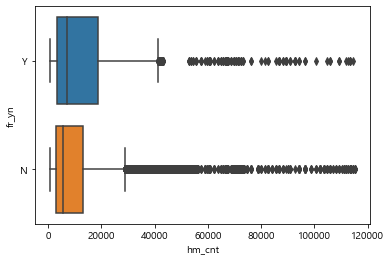

In [67]:
sns.boxplot(x = 'hm_cnt', y='fr_yn' ,data =df_train)

In [138]:
#col_y = df_train[df_train.fr_yn=='Y']
#out_y = get_outlier(col_y.dropna(),'hm_cnt')
#col_n = df_train[df_train.fr_yn=='N']
#out_n = get_outlier(col_n.dropna(),'hm_cnt')

In [125]:
#df_drop_train = df_train.drop(out_y)
#df_drop_train = df_drop_train.drop(out_n)
#df_drop_train.groupby('fr_yn').describe()

hm_cnt                                                               \
         count          mean           std    min     25%     50%       75%   
fr_yn                                                                         
N      46350.0   7650.218986   7417.942834  778.0  2562.0  4530.0  10819.00   
Y       7376.0  11224.809789  10216.198579  814.0  3431.0  6870.0  16985.75   

               fr_sttn_dstnc                                                  \
           max         count         mean         std   min      25%     50%   
fr_yn                                                                          
N      96512.0       46947.0  6245.877202  5012.93744  10.0  1913.00  5266.0   
Y      65676.0        7480.0  4910.514037  4521.54283   5.0  1450.75  3324.0   

                         
           75%      max  
fr_yn                    
N      9229.00  38044.0  
Y      7176.75  35243.0

In [ ]:
#df_drop_train_minmax = df_drop_train.drop(df_drop_train[(df_drop_train['hm_cnt']<=3000)|(df_drop_train['hm_cnt']>=85000)].index)

In [147]:
df_train['hm_cnt'] = df_train['hm_cnt'].apply(lambda x : np.log(1+x))

C:\Users\jaeyong\Anaconda3\envs\cuda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
df_validation['hm_cnt'] = df_validation['hm_cnt'].apply(lambda x : np.log(1+x))

In [128]:
df_validation.groupby('fr_yn').describe()

hm_cnt                                                               \
        count      mean       std       min       25%        50%       75%   
fr_yn                                                                        
N      5625.0  9.738586  1.088776  8.062433  8.952864   9.228573  10.74186   
Y      1272.0  9.885094  1.146146  8.062433  8.964184  10.465158  10.90468   

                 fr_sttn_dstnc                                           \
             max         count         mean          std   min      25%   
fr_yn                                                                     
N      11.357581        5626.0  2293.020441  1387.994487   3.0  1117.00   
Y      11.357581        1272.0  2118.157233  1370.518621  34.0  1020.75   

                               
          50%     75%     max  
fr_yn                          
N      2110.5  3269.0  6985.0  
Y      1874.5  2985.5  7274.0

In [129]:
df_train.groupby('fr_yn').describe()

hm_cnt                                                              \
         count      mean       std       min       25%       50%       75%   
fr_yn                                                                        
N      46350.0  8.557583  0.869898  6.658011  7.848934  8.418698  9.289152   
Y       7376.0  8.893897  0.965651  6.703188  8.140898  8.835065  9.740189   

                 fr_sttn_dstnc                                          \
             max         count         mean         std   min      25%   
fr_yn                                                                    
N      11.477433       46947.0  6245.877202  5012.93744  10.0  1913.00   
Y      11.092504        7480.0  4910.514037  4521.54283   5.0  1450.75   

                                 
          50%      75%      max  
fr_yn                            
N      5266.0  9229.00  38044.0  
Y      3324.0  7176.75  35243.0

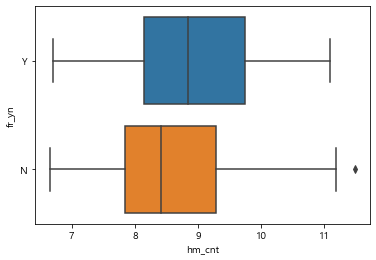

In [130]:
sns.boxplot(x = 'hm_cnt', y='fr_yn' ,data =df_drop_train)

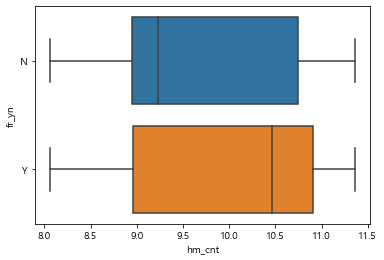

In [131]:
sns.boxplot(x = 'hm_cnt', y='fr_yn' ,data = df_validation)

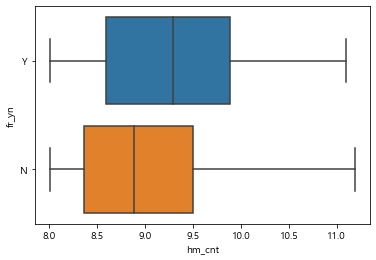

In [112]:
sns.boxplot(x = 'hm_cnt', y='fr_yn' ,data = df_drop_train_minmax)

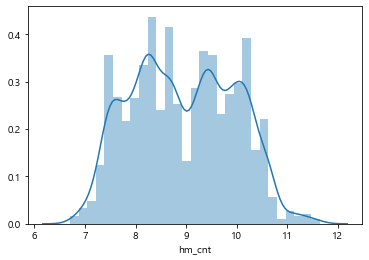

In [150]:
sns.distplot(df_train[df_train['fr_yn']=='Y']['hm_cnt'].dropna(),kde=True)

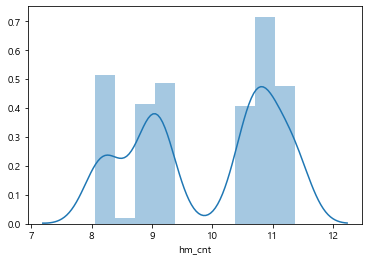

In [151]:
sns.distplot(df_validation[df_validation['fr_yn']=='Y']['hm_cnt'].dropna(),kde=True)

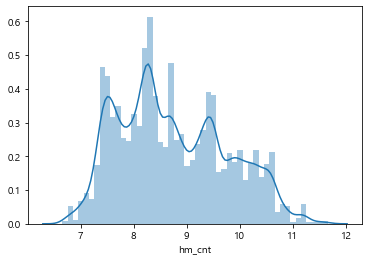

In [153]:
sns.distplot(df_train[df_train['fr_yn']=='N']['hm_cnt'].dropna(),kde=True)

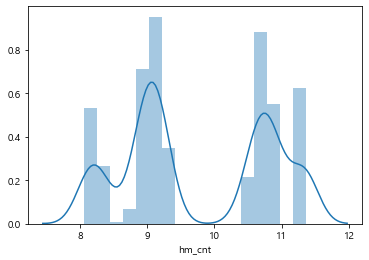

In [154]:
sns.distplot(df_validation[df_validation['fr_yn']=='N']['hm_cnt'].dropna(),kde=True)

# -----------------------------------------------------------------------------------------------------